# Regression modeling for TRIBE2 CanCol 

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

In [2]:
evaluation = {}

## Regression on dpfs using the best measure results
This regression analysis uses the 'best' mutations, as chosen based on the correlations previously computed.
For all regression models, we exclude patients whose disease has not progressed.

In [3]:
patients_log = pd.read_csv("TRIBE2_db.csv")
arm0_best_dataset = pd.read_csv("arm0_best_mutations.csv")
arm0_best_dataset = arm0_best_dataset[
    arm0_best_dataset["PatientFirstName"].isin(
        patients_log[patients_log["1stpfs event"] == 1]["PatientFirstName"]
    )
]
arm1_best_dataset = pd.read_csv("arm1_best_mutations.csv")
arm1_best_dataset = arm1_best_dataset[
    arm1_best_dataset["PatientFirstName"].isin(
        patients_log[patients_log["1stpfs event"] == 1]["PatientFirstName"]
    )
]

In [4]:
avg0_expectancy = pd.Series.mean(arm0_best_dataset["dpfs"])
avg1_expectancy = pd.Series.mean(arm1_best_dataset["dpfs"])
avg0_expectancy, avg1_expectancy

(311.67123287671234, 379.54464285714283)

### Observing the data
As can be seen from the plots below, dpfs has a long tail so it would make sense to take its log and turn it into an approximately normal distribution.

In [5]:
from sklearn.model_selection import train_test_split

arm0_x, arm0_y = (
    arm0_best_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    arm0_best_dataset["dpfs"],
)
arm0_x_train, arm0_x_test, arm0_y_train, arm0_y_test = train_test_split(
    arm0_x, arm0_y, test_size=0.30, random_state=42
)
# Disabled for performance
# train_dataset = arm0_x_train.copy()
# train_dataset.insert(0, "dpfs", arm0_y_train)
# _ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

arm1_x, arm1_y = (
    arm1_best_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    arm1_best_dataset["dpfs"],
)
arm1_x_train, arm1_x_test, arm1_y_train, arm1_y_test = train_test_split(
    arm1_x, arm1_y, test_size=0.30, random_state=42
)
# Disabled for performance
# train_dataset = arm1_x_train.copy()
# train_dataset.insert(0, "dpfs", arm1_y_train)
# _ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

### Linear model

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10
)
evaluation["best-linear"] = {}

#### arm0

In [7]:
_ = model.fit(arm0_x_train, arm0_y_train)

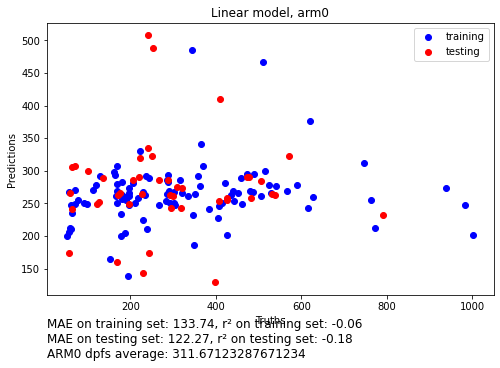

In [8]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Linear model, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-linear"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

In [9]:
arm0_best_coefs = pd.DataFrame(
    model.regressor_.coef_, columns=["Coefficients"], index=arm0_x_train.columns
)
arm0_best_coefs

,Coefficients
CellCycle,-0.002188
HIPPO,0.030883
MYC,0.105542
NOTCH,0.011214
NRF2,0.006070
PI3K,0.002012
RTK-RAS,-339.366911
TGF-Beta,-0.010407
TP53,0.006594
WNT,0.009606


#### arm1

In [10]:
_ = model.fit(arm1_x_train, arm1_y_train)

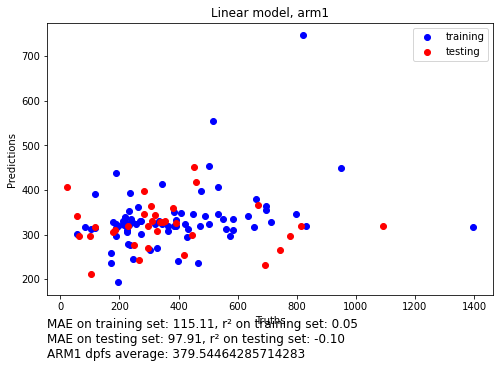

In [11]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Linear model, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-linear"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

In [12]:
arm1_best_coefs = pd.DataFrame(
    model.regressor_.coef_, columns=["Coefficients"], index=arm1_x_train.columns
)
arm1_best_coefs

,Coefficients
CellCycle,-1.328623e-04
HIPPO,-7.976133e-02
MYC,-2.795310e+08
NOTCH,2.618767e-02
NRF2,3.593667e-03
PI3K,3.436960e-03
RTK-RAS,2.505020e-02
TGF-Beta,-7.618272e-03
TP53,1.647086e-02
WNT,-3.964940e-02


### Lasso

In [13]:
from sklearn.linear_model import LassoCV

model = TransformedTargetRegressor(
    regressor=LassoCV(), func=np.log10, inverse_func=sp.special.exp10
)
evaluation["best-lasso"] = {}

#### arm0

In [14]:
_ = model.fit(arm0_x_train, arm0_y_train)

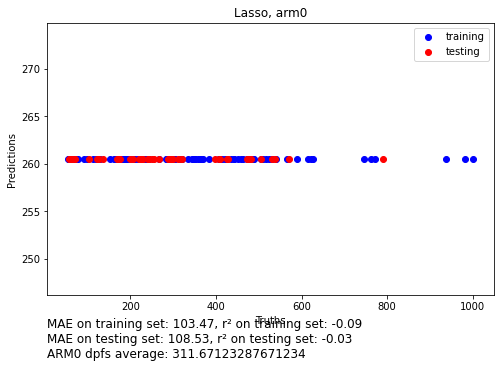

In [15]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Lasso, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-lasso"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

In [16]:
arm0_best_coefs = pd.DataFrame(
    model.regressor_.coef_, columns=["Coefficients"], index=arm0_x_train.columns
)
arm0_best_coefs

,Coefficients
CellCycle,-0.000000e+00
HIPPO,0.000000e+00
MYC,0.000000e+00
NOTCH,0.000000e+00
NRF2,1.769798e-18
PI3K,0.000000e+00
RTK-RAS,-0.000000e+00
TGF-Beta,-0.000000e+00
TP53,-0.000000e+00
WNT,0.000000e+00


#### arm1

In [17]:
_ = model.fit(arm1_x_train, arm1_y_train)

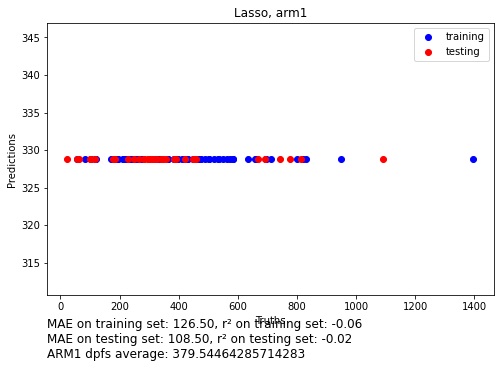

In [18]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Lasso, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-lasso"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

In [19]:
arm1_best_coefs = pd.DataFrame(
    model.regressor_.coef_, columns=["Coefficients"], index=arm1_x_train.columns
)
arm1_best_coefs

,Coefficients
CellCycle,0.0
HIPPO,-0.0
MYC,-0.0
NOTCH,0.0
NRF2,0.0
PI3K,0.0
RTK-RAS,0.0
TGF-Beta,-0.0
TP53,0.0
WNT,-0.0


### Random forest

In [20]:
from sklearn.ensemble import RandomForestRegressor

model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(criterion="mae"),
    func=np.log10,
    inverse_func=sp.special.exp10,
)
evaluation["best-random-forest"] = {}

#### arm0

In [21]:
_ = model.fit(arm0_x_train, arm0_y_train)

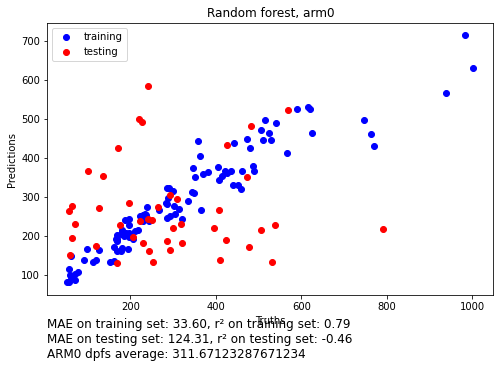

In [22]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-random-forest"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [23]:
_ = model.fit(arm1_x_train, arm1_y_train)

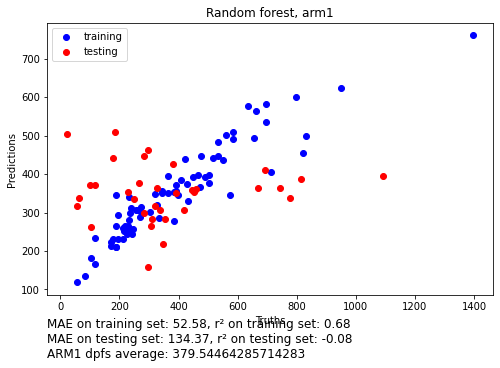

In [24]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-random-forest"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Decision tree

In [25]:
from sklearn.tree import DecisionTreeRegressor

model = TransformedTargetRegressor(
    regressor=DecisionTreeRegressor(criterion="mae", max_depth=10),
    func=np.log10,
    inverse_func=sp.special.exp10,
)
evaluation["best-decision-tree"] = {}

#### arm0

In [26]:
_ = model.fit(arm0_x_train, arm0_y_train)

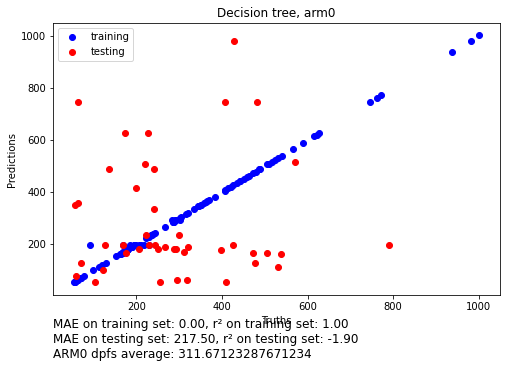

In [27]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-decision-tree"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [28]:
_ = model.fit(arm1_x_train, arm1_y_train)

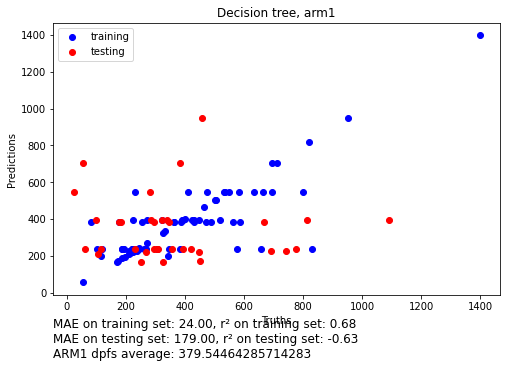

In [29]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-decision-tree"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

----
#### arm0, decision tree best hyperparams

Fitting 5 folds for each of 10 candidates, totalling 50 fits


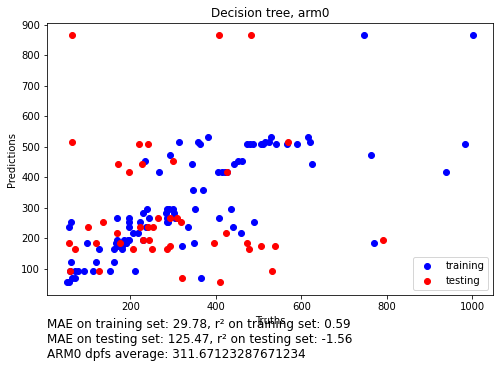

#### arm1, decision tree best hyperparams

Fitting 5 folds for each of 10 candidates, totalling 50 fits


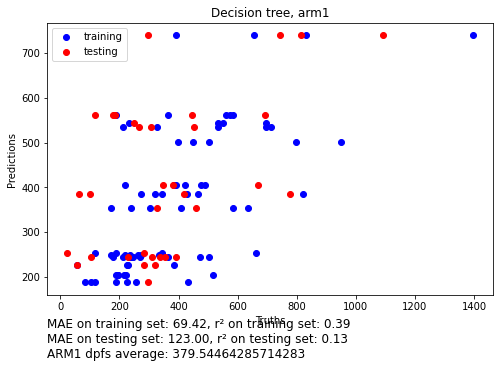

In [30]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import median_absolute_error, r2_score
from IPython.display import display, Markdown

evaluation["best-decision-tree-cv"] = {}

hparams = [
    {
        "regressor__criterion": ["mae"],
        "regressor__max_depth": [int(x) for x in np.linspace(8, 110, num=15)] + [None],
        "regressor__min_samples_split": [2, 5, 7, 10],
        "regressor__min_samples_leaf": [1, 2, 4],
    }
]
model = TransformedTargetRegressor(
    regressor=DecisionTreeRegressor(), func=np.log10, inverse_func=sp.special.exp10
)

cvmodel = RandomizedSearchCV(
    estimator=model,
    param_distributions=hparams,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
display(Markdown("----\n#### arm0, decision tree best hyperparams"))

_ = cvmodel.fit(arm0_x_train, arm0_y_train)

arm0_y_train_pred = cvmodel.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = cvmodel.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-decision-tree-cv"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

display(Markdown("#### arm1, decision tree best hyperparams"))

_ = cvmodel.fit(arm1_x_train, arm1_y_train)

arm1_y_train_pred = cvmodel.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = cvmodel.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-decision-tree-cv"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Support vector regression

In [31]:
from sklearn.svm import SVR

model = model = TransformedTargetRegressor(
    regressor=SVR(kernel="poly"), func=np.log10, inverse_func=sp.special.exp10
)
evaluation["best-svr-poly"] = {}

#### arm0

In [32]:
_ = model.fit(arm0_x_train, arm0_y_train)

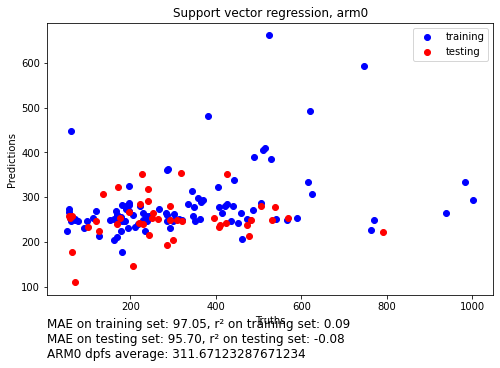

In [33]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Support vector regression, arm0")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-svr-poly"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [34]:
_ = model.fit(arm1_x_train, arm1_y_train)

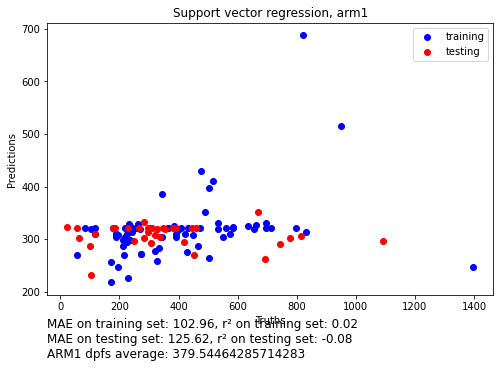

In [35]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Support vector regression, arm1")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["best-svr-poly"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

## Regression on dpfs using all mutation measures

In [36]:
patients_log = pd.read_csv("TRIBE2_db.csv")
arm0_all_dataset = pd.read_csv("arm0_all_mutations.csv")
arm0_all_dataset = arm0_all_dataset[
    arm0_all_dataset["PatientFirstName"].isin(
        patients_log[patients_log["1stpfs event"] == 1]["PatientFirstName"]
    )
]
arm1_all_dataset = pd.read_csv("arm1_all_mutations.csv")
arm1_all_dataset = arm1_all_dataset[
    arm1_all_dataset["PatientFirstName"].isin(
        patients_log[patients_log["1stpfs event"] == 1]["PatientFirstName"]
    )
]

In [37]:
from sklearn.model_selection import train_test_split

arm0_x, arm0_y = (
    arm0_all_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    arm0_all_dataset["dpfs"],
)
arm0_x_train, arm0_x_test, arm0_y_train, arm0_y_test = train_test_split(
    arm0_x, arm0_y, test_size=0.30, random_state=42
)

arm1_x, arm1_y = (
    arm1_all_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    arm1_all_dataset["dpfs"],
)
arm1_x_train, arm1_x_test, arm1_y_train, arm1_y_test = train_test_split(
    arm1_x, arm1_y, test_size=0.30, random_state=42
)

### Linear model

In [38]:
from sklearn.linear_model import LinearRegression

model = TransformedTargetRegressor(
    regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10
)
evaluation["all-linear"] = {}

#### arm0

In [39]:
_ = model.fit(arm0_x_train, arm0_y_train)

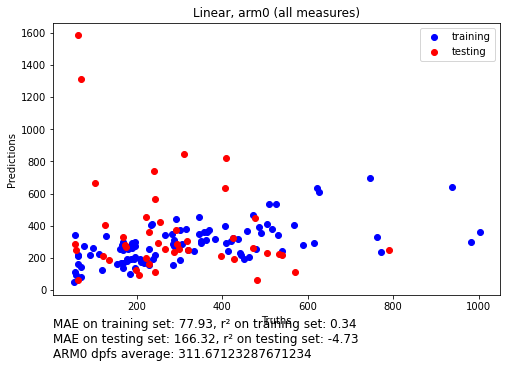

In [40]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Linear, arm0 (all measures)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-linear"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

In [41]:
arm0_all_coefs = pd.DataFrame(
    model.regressor_.coef_, columns=["Coefficients"], index=arm0_x_train.columns
)
arm0_all_coefs

,Coefficients
CellCycle,3.207684e+08
HIPPO,-8.150501e+07
MYC,2.055901e+07
NOTCH,-1.725085e+08
NRF2,-3.735105e+08
...,...
eigenvector_centrality_numpy_H_PI3K,-1.104450e+09
eigenvector_centrality_numpy_H_RTK-RAS,5.670168e+08
eigenvector_centrality_numpy_H_TGF-Beta,5.134919e+06
eigenvector_centrality_numpy_H_TP53,-7.647295e+08


#### arm1

In [42]:
_ = model.fit(arm1_x_train, arm1_y_train)

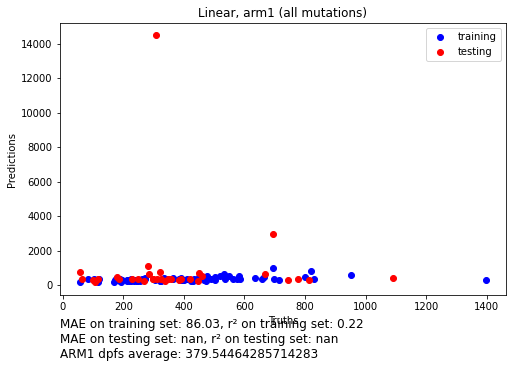

In [43]:
import math

arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Linear, arm1 (all mutations)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

# something here explodes to infinity
arm1_y_pred = model.predict(arm1_x_test)
mae = math.nan  # median_absolute_error(arm1_y_test, arm1_y_pred, allow_nan=True)
r2 = math.nan  # r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-linear"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Lasso

In [44]:
from sklearn.linear_model import LassoCV

model = TransformedTargetRegressor(
    regressor=LassoCV(), func=np.log10, inverse_func=sp.special.exp10
)
evaluation["all-lasso"] = {}

#### arm0

In [45]:
_ = model.fit(arm0_x_train, arm0_y_train)

/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009952638663195401, tolerance: 0.0008005498443054915
  model = cd_fast.enet_coordinate_descent(
/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012443514830664526, tolerance: 0.0008005498443054915
  model = cd_fast.enet_coordinate_descent(
/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012848195637458204, tolerance: 0.0008005498443054915
  model = cd_fast.enet_coordinate_descent(
/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: C

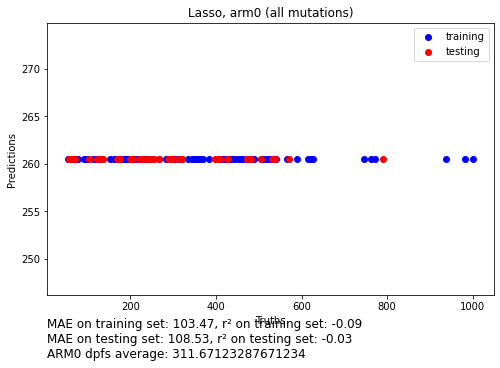

In [46]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Lasso, arm0 (all mutations)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-lasso"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

In [47]:
arm0_best_coefs = pd.DataFrame(
    model.regressor_.coef_, columns=["Coefficients"], index=arm0_x_train.columns
)
arm0_best_coefs

,Coefficients
CellCycle,-0.0
HIPPO,0.0
MYC,0.0
NOTCH,0.0
NRF2,0.0
...,...
eigenvector_centrality_numpy_H_PI3K,0.0
eigenvector_centrality_numpy_H_RTK-RAS,-0.0
eigenvector_centrality_numpy_H_TGF-Beta,-0.0
eigenvector_centrality_numpy_H_TP53,-0.0


#### arm1

In [48]:
_ = model.fit(arm1_x_train, arm1_y_train)

/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007969336444766384, tolerance: 0.00043290962478662704
  model = cd_fast.enet_coordinate_descent(
/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013033314954666864, tolerance: 0.00043290962478662704
  model = cd_fast.enet_coordinate_descent(
/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014723419902740176, tolerance: 0.00043290962478662704
  model = cd_fast.enet_coordinate_descent(
/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530

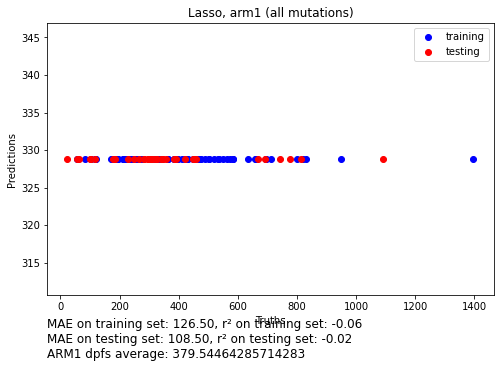

In [49]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Lasso, arm1 (all mutations)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-lasso"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

In [50]:
arm1_best_coefs = pd.DataFrame(
    model.regressor_.coef_, columns=["Coefficients"], index=arm1_x_train.columns
)
arm1_best_coefs

,Coefficients
CellCycle,0.0
HIPPO,-0.0
MYC,-0.0
NOTCH,0.0
NRF2,0.0
...,...
eigenvector_centrality_numpy_H_PI3K,-0.0
eigenvector_centrality_numpy_H_RTK-RAS,-0.0
eigenvector_centrality_numpy_H_TGF-Beta,-0.0
eigenvector_centrality_numpy_H_TP53,0.0


### Random forest

In [51]:
from sklearn.ensemble import RandomForestRegressor

model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(criterion="mae"),
    func=np.log10,
    inverse_func=sp.special.exp10,
)
evaluation["all-random-forest"] = {}

#### arm0

In [52]:
_ = model.fit(arm0_x_train, arm0_y_train)

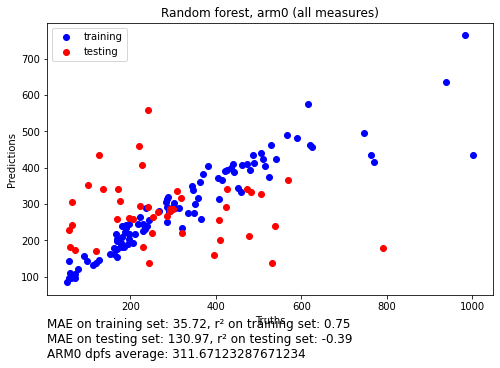

In [53]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm0 (all measures)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-random-forest"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [54]:
_ = model.fit(arm1_x_train, arm1_y_train)

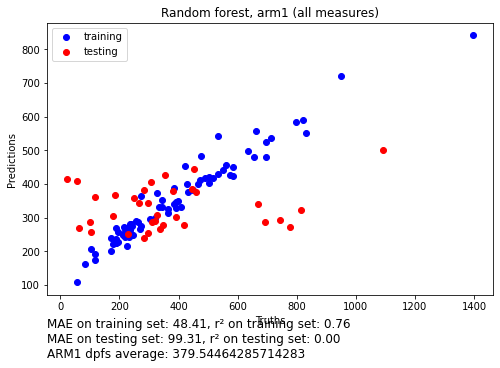

In [55]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm1 (all measures)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-random-forest"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Decision tree

In [56]:
from sklearn.tree import DecisionTreeRegressor

model = TransformedTargetRegressor(
    regressor=DecisionTreeRegressor(criterion="mae", max_depth=10),
    func=np.log10,
    inverse_func=sp.special.exp10,
)
evaluation["all-decision-tree"] = {}

#### arm0

In [57]:
_ = model.fit(arm0_x_train, arm0_y_train)

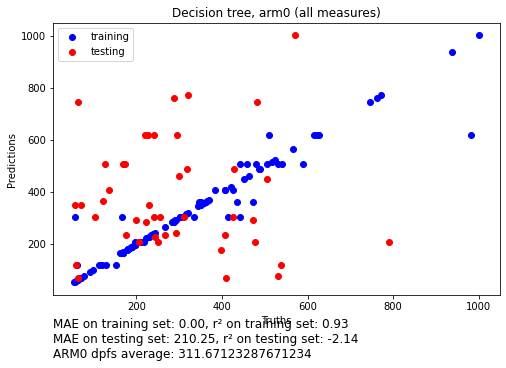

In [58]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm0 (all measures)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-decision-tree"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [59]:
_ = model.fit(arm1_x_train, arm1_y_train)

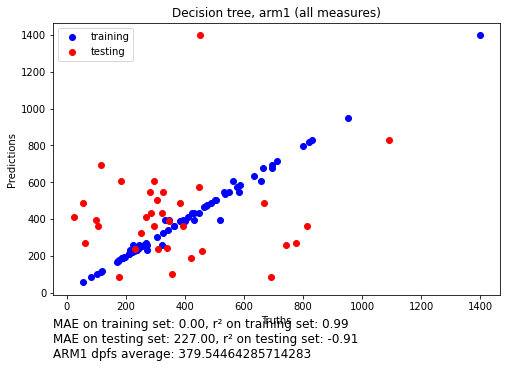

In [60]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm1 (all measures)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-decision-tree"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Support vector regression

In [61]:
from sklearn.svm import SVR

model = TransformedTargetRegressor(
    regressor=SVR(kernel="poly"), func=np.log10, inverse_func=sp.special.exp10
)
evaluation["all-svr-poly"] = {}

#### arm0

In [62]:
_ = model.fit(arm0_x_train, arm0_y_train)

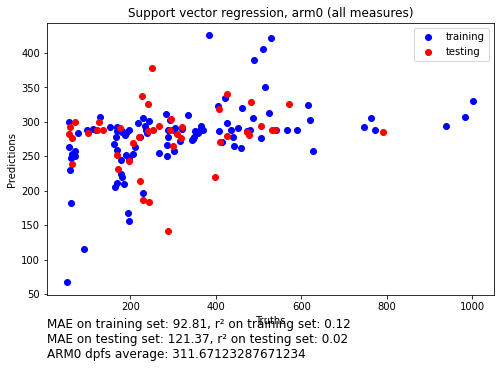

In [63]:
from sklearn.metrics import median_absolute_error, r2_score

arm0_y_train_pred = model.predict(arm0_x_train)
mae_train = median_absolute_error(arm0_y_train, arm0_y_train_pred)
r2_train = r2_score(arm0_y_train, arm0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm0_y_train, arm0_y_train_pred, c="blue", label="training")
plt.title("Support vector regression, arm0 (all measures)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm0_y_pred = model.predict(arm0_x_test)
mae = median_absolute_error(arm0_y_test, arm0_y_pred)
r2 = r2_score(arm0_y_test, arm0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(arm0_y_test, arm0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-svr-poly"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [64]:
_ = model.fit(arm1_x_train, arm1_y_train)

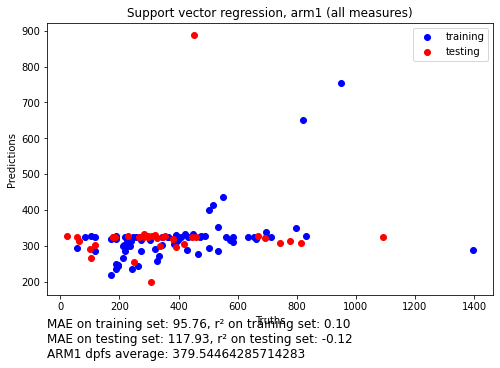

In [65]:
arm1_y_train_pred = model.predict(arm1_x_train)
mae_train = median_absolute_error(arm1_y_train, arm1_y_train_pred)
r2_train = r2_score(arm1_y_train, arm1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(arm1_y_train, arm1_y_train_pred, c="blue", label="training")
plt.title("Support vector regression, arm1 (all measures)")
plt.ylabel("Predictions")
plt.xlabel("Truths")

arm1_y_pred = model.predict(arm1_x_test)
mae = median_absolute_error(arm1_y_test, arm1_y_pred)
r2 = r2_score(arm1_y_test, arm1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(arm1_y_test, arm1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["all-svr-poly"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

## Regression on dpfs with the patients' clinical information
Now for a different course of action: let's try to build a model on top of clinical parameters, which can later be combined with the pathway mutations for (hopefully) better results.

In [66]:
clinical = pd.read_csv("TRIBE2_db.csv")
clinical_a0 = clinical[(clinical["arm"] == 0) & (clinical["1stpfs event"] == 1)][
    [
        "age @random",
        "tstag",
        "nstag",
        "liver",
        "lung",
        "nodes",
        "peritoneum",
        "other",
        "ras",
        "braf",
        "dpfs",
    ]
]
clinical_a1 = clinical[(clinical["arm"] == 1) & (clinical["1stpfs event"] == 1)][
    [
        "age @random",
        "tstag",
        "nstag",
        "liver",
        "lung",
        "nodes",
        "peritoneum",
        "other",
        "ras",
        "braf",
        "dpfs",
    ]
]

# Dataset contains null values, encoded in all sort of ways..
clinical_a0 = clinical_a0[
    (clinical_a0["tstag"] != -99)
    & (clinical_a0["nstag"] != -99)
    & (clinical_a0["tstag"] != -99)
    & (clinical_a0["liver"] != -99)
    & (clinical_a0["lung"] != -99)
    & (clinical_a0["peritoneum"] != -99)
    & (clinical_a0["other"] != -99)
    & (clinical_a0["ras"].isin([0, 1]))
    & (clinical_a0["braf"].isin([0, 1]))
]
clinical_a1 = clinical_a1[
    (clinical_a1["tstag"] != -99)
    & (clinical_a1["nstag"] != -99)
    & (clinical_a1["tstag"] != -99)
    & (clinical_a1["liver"] != -99)
    & (clinical_a1["lung"] != -99)
    & (clinical_a1["peritoneum"] != -99)
    & (clinical_a1["other"] != -99)
    & (clinical_a1["ras"].isin([0, 1]))
    & (clinical_a1["braf"].isin([0, 1]))
]

In [67]:
c0_x, c0_y = (
    clinical_a0.drop("dpfs", axis="columns"),
    clinical_a0["dpfs"],
)
c0_x_train, c0_x_test, c0_y_train, c0_y_test = train_test_split(
    c0_x, c0_y, test_size=0.30, random_state=42
)

c1_x, c1_y = (
    clinical_a1.drop("dpfs", axis="columns"),
    clinical_a1["dpfs"],
)
c1_x_train, c1_x_test, c1_y_train, c1_y_test = train_test_split(
    c1_x, c1_y, test_size=0.30, random_state=42
)

### Data visualization

In [68]:
# trrain_dataset = c0_x_train.copy()
# train_dataset.insert(0, "dpfs", c0_y_train)
# = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

# train_dataset = c1_x_train.copy()
# train_dataset.insert(0, "dpfs", c1_y_train)
# _ = sns.pairplot(train_dataset, kind="reg", diag_kind="kde")

### Ridge model

In [69]:
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
)

#### arm0

In [70]:
_ = model.fit(c0_x_train, c0_y_train)
evaluation["clinical-ridge"] = {}

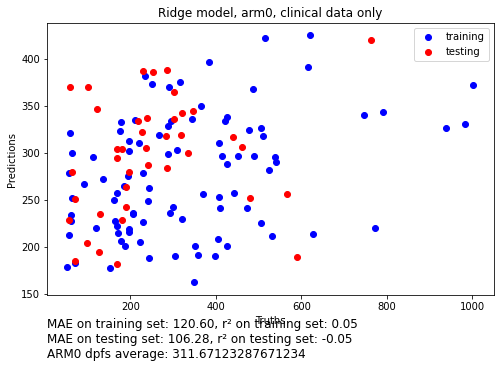

In [71]:
from sklearn.metrics import median_absolute_error, r2_score

c0_y_train_pred = model.predict(c0_x_train)
mae_train = median_absolute_error(c0_y_train, c0_y_train_pred)
r2_train = r2_score(c0_y_train, c0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c0_y_train, c0_y_train_pred, c="blue", label="training")
plt.title("Ridge model, arm0, clinical data only")
plt.ylabel("Predictions")
plt.xlabel("Truths")

c0_y_pred = model.predict(c0_x_test)
mae = median_absolute_error(c0_y_test, c0_y_pred)
r2 = r2_score(c0_y_test, c0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(c0_y_test, c0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-ridge"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [72]:
_ = model.fit(c1_x_train, c1_y_train)

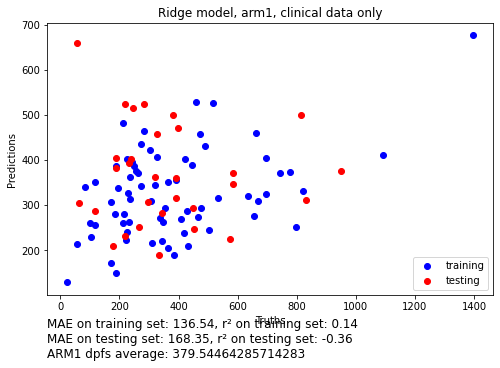

In [73]:
from sklearn.metrics import median_absolute_error, r2_score

c1_y_train_pred = model.predict(c1_x_train)
mae_train = median_absolute_error(c1_y_train, c1_y_train_pred)
r2_train = r2_score(c1_y_train, c1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c1_y_train, c1_y_train_pred, c="blue", label="training")
plt.title("Ridge model, arm1, clinical data only")
plt.ylabel("Predictions")
plt.xlabel("Truths")

c1_y_pred = model.predict(c1_x_test)
mae = median_absolute_error(c1_y_test, c1_y_pred)
r2 = r2_score(c1_y_test, c1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(c1_y_test, c1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-ridge"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Random forest

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(), func=np.log10, inverse_func=sp.special.exp10
)

#### arm0

In [75]:
_ = model.fit(c0_x_train, c0_y_train)
evaluation["clinical-random-forest"] = {}

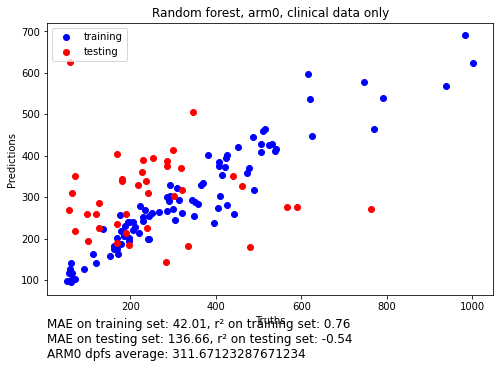

In [76]:
from sklearn.metrics import median_absolute_error, r2_score

c0_y_train_pred = model.predict(c0_x_train)
mae_train = median_absolute_error(c0_y_train, c0_y_train_pred)
r2_train = r2_score(c0_y_train, c0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c0_y_train, c0_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm0, clinical data only")
plt.ylabel("Predictions")
plt.xlabel("Truths")

c0_y_pred = model.predict(c0_x_test)
mae = median_absolute_error(c0_y_test, c0_y_pred)
r2 = r2_score(c0_y_test, c0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(c0_y_test, c0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-random-forest"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [77]:
_ = model.fit(c1_x_train, c1_y_train)

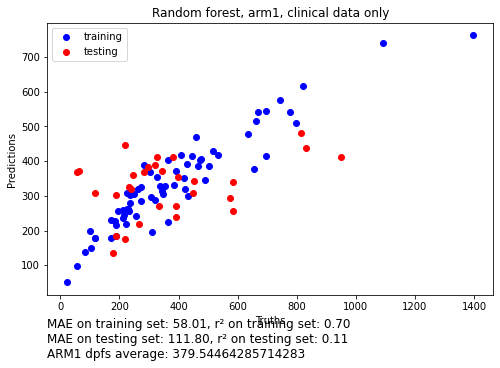

In [78]:
from sklearn.metrics import median_absolute_error, r2_score

c1_y_train_pred = model.predict(c1_x_train)
mae_train = median_absolute_error(c1_y_train, c1_y_train_pred)
r2_train = r2_score(c1_y_train, c1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c1_y_train, c1_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm1, clinical data only")
plt.ylabel("Predictions")
plt.xlabel("Truths")

c1_y_pred = model.predict(c1_x_test)
mae = median_absolute_error(c1_y_test, c1_y_pred)
r2 = r2_score(c1_y_test, c1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(c1_y_test, c1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-random-forest"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Decision tree

In [79]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=DecisionTreeRegressor(
        criterion="mae", max_depth=10, min_samples_split=10
    ),
    func=np.log10,
    inverse_func=sp.special.exp10,
)

#### arm0

In [80]:
_ = model.fit(c0_x_train, c0_y_train)
evaluation["clinical-decision-tree"] = {}

In [81]:
from six import StringIO
from sklearn import tree
import graphviz

dot_data = StringIO()
tree.export_graphviz(
    model.regressor_,
    out_file=dot_data,
    feature_names=c0_x_train.columns,
    filled=True,
    rounded=True,
    impurity=True,
)
graph = graphviz.Source(dot_data.getvalue())
graph.render("clinical-decision-tree-arm0.gv")

'clinical-decision-tree-arm0.gv.pdf'

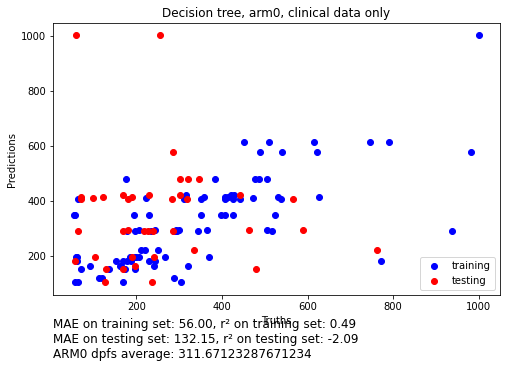

In [82]:
from sklearn.metrics import median_absolute_error, r2_score

c0_y_train_pred = model.predict(c0_x_train)
mae_train = median_absolute_error(c0_y_train, c0_y_train_pred)
r2_train = r2_score(c0_y_train, c0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c0_y_train, c0_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm0, clinical data only")
plt.ylabel("Predictions")
plt.xlabel("Truths")

c0_y_pred = model.predict(c0_x_test)
mae = median_absolute_error(c0_y_test, c0_y_pred)
r2 = r2_score(c0_y_test, c0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(c0_y_test, c0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-decision-tree"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [83]:
_ = model.fit(c1_x_train, c1_y_train)

In [84]:
from six import StringIO
from sklearn import tree
import graphviz

dot_data = StringIO()
tree.export_graphviz(
    model.regressor_,
    out_file=dot_data,
    feature_names=c1_x_train.columns,
    filled=True,
    rounded=True,
    impurity=True,
)
graph = graphviz.Source(dot_data.getvalue())
graph.render("clinical-decision-tree-arm1.gv")

'clinical-decision-tree-arm1.gv.pdf'

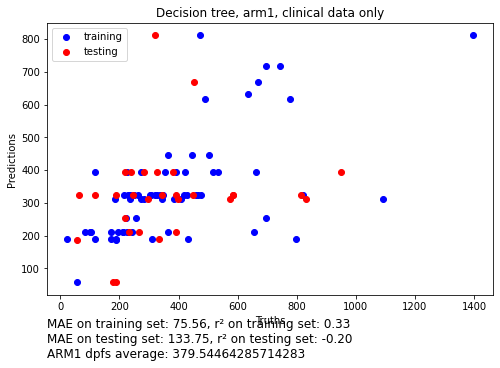

In [85]:
from sklearn.metrics import median_absolute_error, r2_score

c1_y_train_pred = model.predict(c1_x_train)
mae_train = median_absolute_error(c1_y_train, c1_y_train_pred)
r2_train = r2_score(c1_y_train, c1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c1_y_train, c1_y_train_pred, c="blue", label="training")
plt.title("Decision tree, arm1, clinical data only")
plt.ylabel("Predictions")
plt.xlabel("Truths")

c1_y_pred = model.predict(c1_x_test)
mae = median_absolute_error(c1_y_test, c1_y_pred)
r2 = r2_score(c1_y_test, c1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(c1_y_test, c1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-decision-tree"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

----
#### arm0, decision tree best hyperparams

Fitting 5 folds for each of 10 candidates, totalling 50 fits


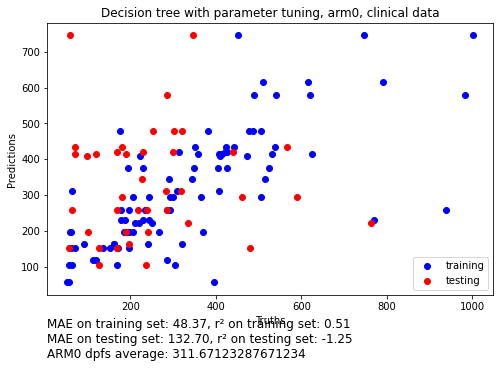

#### arm1, decision tree best hyperparams

Fitting 5 folds for each of 10 candidates, totalling 50 fits


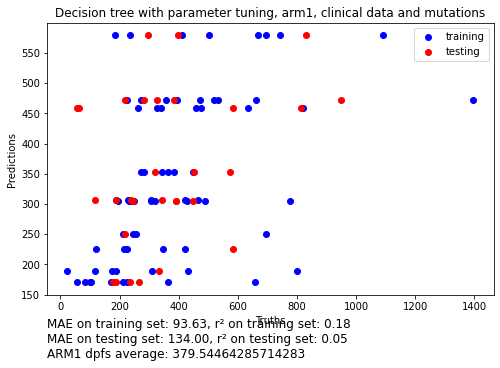

In [86]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import median_absolute_error, r2_score
from IPython.display import display, Markdown

evaluation["clinical-decision-tree-cv"] = {}

hparams = [
    {
        "regressor__criterion": ["mae"],
        "regressor__max_depth": [int(x) for x in np.linspace(8, 110, num=15)] + [None],
        "regressor__min_samples_split": [2, 5, 7, 10],
        "regressor__min_samples_leaf": [1, 2, 4],
    }
]
model = TransformedTargetRegressor(
    regressor=DecisionTreeRegressor(), func=np.log10, inverse_func=sp.special.exp10
)

cvmodel = RandomizedSearchCV(
    estimator=model,
    param_distributions=hparams,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
display(Markdown("----\n#### arm0, decision tree best hyperparams"))

_ = cvmodel.fit(c0_x_train, c0_y_train)

cv_c0_y_train_pred = cvmodel.predict(c0_x_train)
mae_train = median_absolute_error(c0_y_train, cv_c0_y_train_pred)
r2_train = r2_score(c0_y_train, cv_c0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c0_y_train, cv_c0_y_train_pred, c="blue", label="training")
plt.title("Decision tree with parameter tuning, arm0, clinical data")
plt.ylabel("Predictions")
plt.xlabel("Truths")

cv_c0_y_pred = cvmodel.predict(c0_x_test)
mae = median_absolute_error(c0_y_test, cv_c0_y_pred)
r2 = r2_score(c0_y_test, cv_c0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(c0_y_test, cv_c0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()
evaluation["clinical-decision-tree-cv"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

display(Markdown("#### arm1, decision tree best hyperparams"))

_ = cvmodel.fit(c1_x_train, c1_y_train)

cv_c1_y_train_pred = cvmodel.predict(c1_x_train)
mae_train = median_absolute_error(c1_y_train, cv_c1_y_train_pred)
r2_train = r2_score(c1_y_train, cv_c1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(c1_y_train, cv_c1_y_train_pred, c="blue", label="training")
plt.title("Decision tree with parameter tuning, arm1, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

cv_c1_y_pred = cvmodel.predict(c1_x_test)
mae = median_absolute_error(c1_y_test, cv_c1_y_pred)
r2 = r2_score(c1_y_test, cv_c1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(c1_y_test, cv_c1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()
evaluation["clinical-decision-tree-cv"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

## Regression on dpfs using all measure results, factoring in clinical data

In [87]:
temp_a0 = clinical[(clinical["arm"] == 0) & (clinical["1stpfs event"] == 1)][
    [
        "PatientFirstName",
        "age @random",
        "tstag",
        "nstag",
        "liver",
        "lung",
        "nodes",
        "peritoneum",
        "other",
        "ras",
        "braf",
    ]
]
temp_a1 = clinical[(clinical["arm"] == 1) & (clinical["1stpfs event"] == 1)][
    [
        "PatientFirstName",
        "age @random",
        "tstag",
        "nstag",
        "liver",
        "lung",
        "nodes",
        "peritoneum",
        "other",
        "ras",
        "braf",
    ]
]

# Dataset contains null values, encoded in all sort of ways..
temp_a0 = temp_a0[
    (temp_a0["tstag"] != -99)
    & (temp_a0["nstag"] != -99)
    & (temp_a0["tstag"] != -99)
    & (temp_a0["liver"] != -99)
    & (temp_a0["lung"] != -99)
    & (temp_a0["peritoneum"] != -99)
    & (temp_a0["other"] != -99)
    & (temp_a0["ras"].isin([0, 1]))
    & (temp_a0["braf"].isin([0, 1]))
]
temp_a1 = temp_a1[
    (temp_a1["tstag"] != -99)
    & (temp_a1["nstag"] != -99)
    & (temp_a1["tstag"] != -99)
    & (temp_a1["liver"] != -99)
    & (temp_a1["lung"] != -99)
    & (temp_a1["peritoneum"] != -99)
    & (temp_a1["other"] != -99)
    & (temp_a1["ras"].isin([0, 1]))
    & (temp_a1["braf"].isin([0, 1]))
]

ca0_dataset = temp_a0.join(
    arm0_all_dataset.set_index("PatientFirstName"), on="PatientFirstName"
)
# ca0_dataset = ca0_dataset[(ca0_dataset["dpfs"] < 400)]
ca1_dataset = temp_a1.join(
    arm1_all_dataset.set_index("PatientFirstName"), on="PatientFirstName"
)
# ca1_dataset = ca1_dataset[(ca1_dataset["dpfs"] < 400)]

In [88]:
ca0_x, ca0_y = (
    ca0_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    ca0_dataset["dpfs"],
)
ca0_x_train, ca0_x_test, ca0_y_train, ca0_y_test = train_test_split(
    ca0_x, ca0_y, test_size=0.30, random_state=42
)

ca1_x, ca1_y = (
    ca1_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    ca1_dataset["dpfs"],
)
ca1_x_train, ca1_x_test, ca1_y_train, ca1_y_test = train_test_split(
    ca1_x, ca1_y, test_size=0.30, random_state=42
)

### Ridge model

In [89]:
from sklearn.linear_model import Ridge
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=Ridge(alpha=1e-10), func=np.log10, inverse_func=sp.special.exp10
)

#### arm0

In [90]:
_ = model.fit(ca0_x_train, ca0_y_train)
evaluation["clinical-all-ridge"] = {}

/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.90224e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


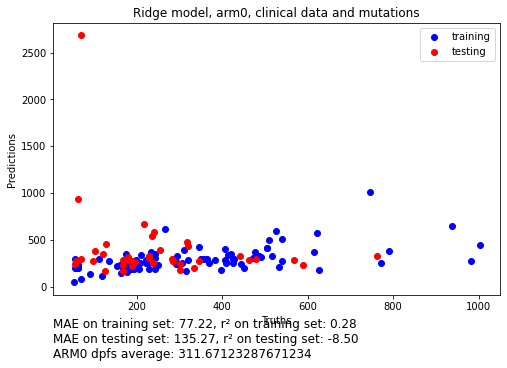

In [91]:
from sklearn.metrics import median_absolute_error, r2_score

ca0_y_train_pred = model.predict(ca0_x_train)
mae_train = median_absolute_error(ca0_y_train, ca0_y_train_pred)
r2_train = r2_score(ca0_y_train, ca0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca0_y_train, ca0_y_train_pred, c="blue", label="training")
plt.title("Ridge model, arm0, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

ca0_y_pred = model.predict(ca0_x_test)
mae = median_absolute_error(ca0_y_test, ca0_y_pred)
r2 = r2_score(ca0_y_test, ca0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(ca0_y_test, ca0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-all-ridge"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [92]:
_ = model.fit(ca1_x_train, ca1_y_train)

/opt/jupyter/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=8.77741e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


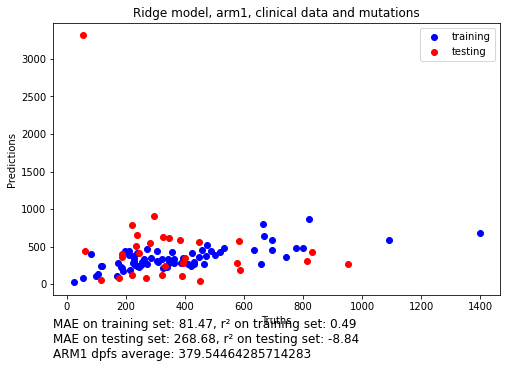

In [93]:
from sklearn.metrics import median_absolute_error, r2_score

ca1_y_train_pred = model.predict(ca1_x_train)
mae_train = median_absolute_error(ca1_y_train, ca1_y_train_pred)
r2_train = r2_score(ca1_y_train, ca1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca1_y_train, ca1_y_train_pred, c="blue", label="training")
plt.title("Ridge model, arm1, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

ca1_y_pred = model.predict(ca1_x_test)
mae = median_absolute_error(ca1_y_test, ca1_y_pred)
r2 = r2_score(ca1_y_test, ca1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(ca1_y_test, ca1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-all-ridge"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Random forest

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(), func=np.log10, inverse_func=sp.special.exp10
)

#### arm0

In [95]:
_ = model.fit(ca0_x_train, ca0_y_train)
evaluation["clinical-all-random-forest"] = {}

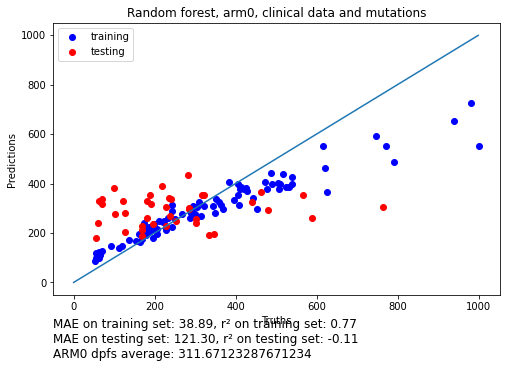

In [96]:
from sklearn.metrics import median_absolute_error, r2_score

ca0_y_train_pred = model.predict(ca0_x_train)
mae_train = median_absolute_error(ca0_y_train, ca0_y_train_pred)
r2_train = r2_score(ca0_y_train, ca0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca0_y_train, ca0_y_train_pred, c="blue", label="training")
plt.plot(range(1000), range(1000))
plt.title("Random forest, arm0, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

ca0_y_pred = model.predict(ca0_x_test)
mae = median_absolute_error(ca0_y_test, ca0_y_pred)
r2 = r2_score(ca0_y_test, ca0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(ca0_y_test, ca0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-all-random-forest"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [97]:
_ = model.fit(ca1_x_train, ca1_y_train)

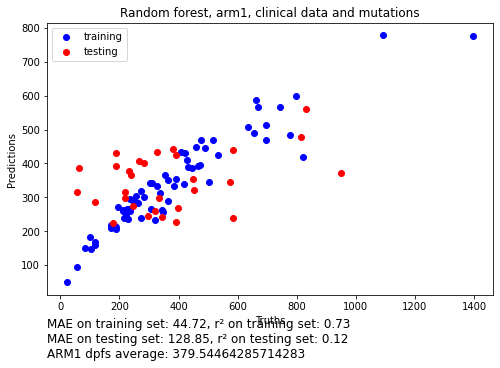

In [98]:
from sklearn.metrics import median_absolute_error, r2_score

ca1_y_train_pred = model.predict(ca1_x_train)
mae_train = median_absolute_error(ca1_y_train, ca1_y_train_pred)
r2_train = r2_score(ca1_y_train, ca1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca1_y_train, ca1_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm1, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

ca1_y_pred = model.predict(ca1_x_test)
mae = median_absolute_error(ca1_y_test, ca1_y_pred)
r2 = r2_score(ca1_y_test, ca1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(ca1_y_test, ca1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-all-random-forest"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

----
#### arm0, random forest best hyperparams

Fitting 5 folds for each of 10 candidates, totalling 50 fits


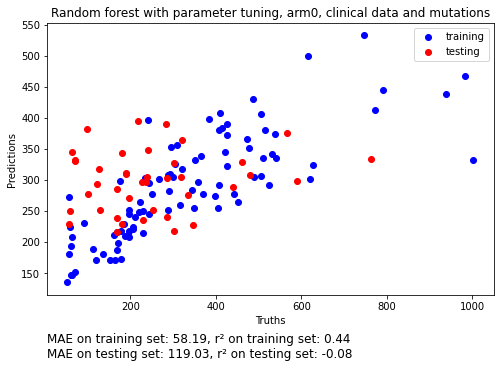

#### arm1, random forest best hyperparams

Fitting 5 folds for each of 10 candidates, totalling 50 fits


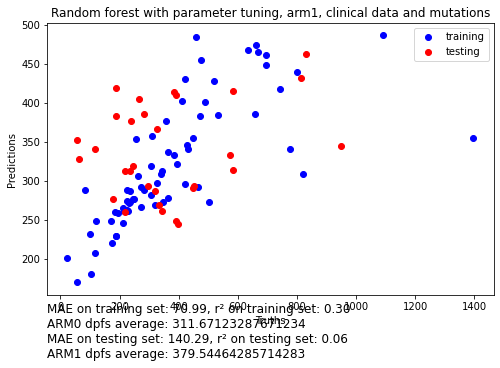

In [99]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import median_absolute_error, r2_score
from IPython.display import display, Markdown

evaluation["clinical-all-random-forest-cv"] = {}

hparams = [
    {
        "regressor__criterion": ["mae"],
        "regressor__max_features": ["auto", "sqrt"],
        "regressor__max_depth": [int(x) for x in np.linspace(8, 110, num=15)] + [None],
        "regressor__min_samples_split": [2, 5, 7, 10],
        "regressor__min_samples_leaf": [1, 2, 4],
    }
]
model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(), func=np.log10, inverse_func=sp.special.exp10
)

cvmodel = RandomizedSearchCV(
    estimator=model,
    param_distributions=hparams,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
)
display(Markdown("----\n#### arm0, random forest best hyperparams"))

_ = cvmodel.fit(ca0_x_train, ca0_y_train)

cv_ca0_y_train_pred = cvmodel.predict(ca0_x_train)
mae_train = median_absolute_error(ca0_y_train, cv_ca0_y_train_pred)
r2_train = r2_score(ca0_y_train, cv_ca0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca0_y_train, cv_ca0_y_train_pred, c="blue", label="training")
plt.title("Random forest with parameter tuning, arm0, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

cv_ca0_y_pred = cvmodel.predict(ca0_x_test)
mae = median_absolute_error(ca0_y_test, cv_ca0_y_pred)
r2 = r2_score(ca0_y_test, cv_ca0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"

plt.scatter(ca0_y_test, cv_ca0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()
evaluation["clinical-all-random-forest-cv"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

display(Markdown("#### arm1, random forest best hyperparams"))

_ = cvmodel.fit(ca1_x_train, ca1_y_train)

cv_ca1_y_train_pred = cvmodel.predict(ca1_x_train)
mae_train = median_absolute_error(ca1_y_train, cv_ca1_y_train_pred)
r2_train = r2_score(ca1_y_train, cv_ca1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca1_y_train, cv_ca1_y_train_pred, c="blue", label="training")
plt.title("Random forest with parameter tuning, arm1, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

cv_ca1_y_pred = cvmodel.predict(ca1_x_test)
mae = median_absolute_error(ca1_y_test, cv_ca1_y_pred)
r2 = r2_score(ca1_y_test, cv_ca1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(ca1_y_test, cv_ca1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()
evaluation["clinical-all-random-forest-cv"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

### Support vector regressor

In [100]:
from sklearn.svm import SVR
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=SVR(C=15, epsilon=0.05, gamma=0.05, kernel="rbf"),
    func=np.log10,
    inverse_func=sp.special.exp10,
)

#### arm0

In [101]:
_ = model.fit(ca0_x_train, ca0_y_train)
evaluation["clinical-all-svr-rbf"] = {}

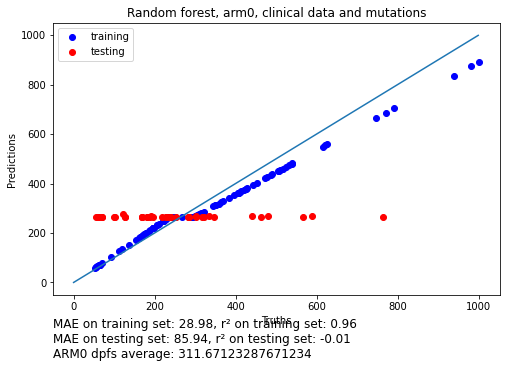

In [102]:
from sklearn.metrics import median_absolute_error, r2_score

ca0_y_train_pred = model.predict(ca0_x_train)
mae_train = median_absolute_error(ca0_y_train, ca0_y_train_pred)
r2_train = r2_score(ca0_y_train, ca0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca0_y_train, ca0_y_train_pred, c="blue", label="training")
plt.plot(range(1000), range(1000))
plt.title("Random forest, arm0, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

ca0_y_pred = model.predict(ca0_x_test)
mae = median_absolute_error(ca0_y_test, ca0_y_pred)
r2 = r2_score(ca0_y_test, ca0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM0 dpfs average: {avg0_expectancy}"

plt.scatter(ca0_y_test, ca0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-all-svr-rbf"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

#### arm1

In [103]:
_ = model.fit(ca1_x_train, ca1_y_train)

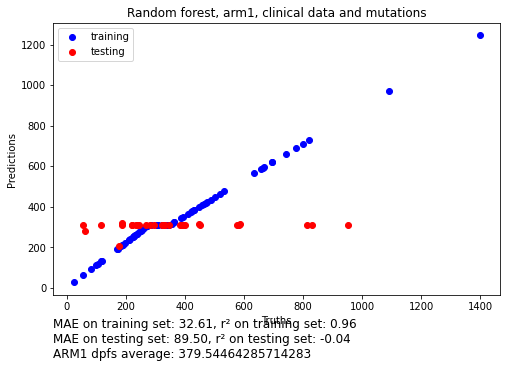

In [104]:
from sklearn.metrics import median_absolute_error, r2_score

ca1_y_train_pred = model.predict(ca1_x_train)
mae_train = median_absolute_error(ca1_y_train, ca1_y_train_pred)
r2_train = r2_score(ca1_y_train, ca1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca1_y_train, ca1_y_train_pred, c="blue", label="training")
plt.title("Random forest, arm1, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

ca1_y_pred = model.predict(ca1_x_test)
mae = median_absolute_error(ca1_y_test, ca1_y_pred)
r2 = r2_score(ca1_y_test, ca1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"
score += f"\nARM1 dpfs average: {avg1_expectancy}"

plt.scatter(ca1_y_test, ca1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()

evaluation["clinical-all-svr-rbf"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

----
#### arm0, svr best hyperparams

Fitting 5 folds for each of 20 candidates, totalling 100 fits


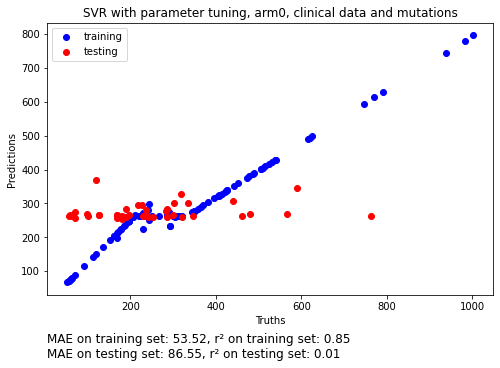

#### arm1, svr best hyperparams

Fitting 5 folds for each of 20 candidates, totalling 100 fits


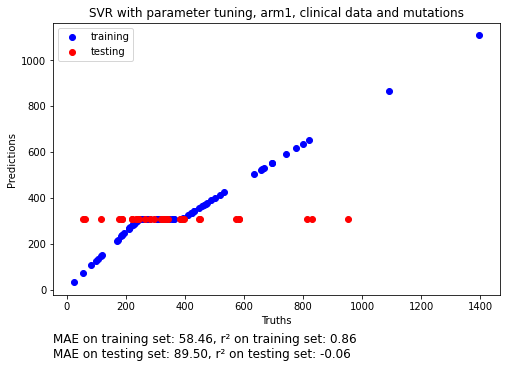

In [105]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import median_absolute_error, r2_score
from IPython.display import display, Markdown

evaluation["clinical-all-svr-rbf-cv"] = {}

hparams = [
    {
        "regressor__kernel": ["rbf"],
        "regressor__cache_size": [300],
        "regressor__gamma": np.logspace(-2, 2, 5),
        "regressor__C": [1e0, 1e1, 1e2, 1e3],
    }
]
model = TransformedTargetRegressor(
    regressor=SVR(), func=np.log10, inverse_func=sp.special.exp10
)

cvmodel = GridSearchCV(
    estimator=model,
    param_grid=hparams,
    scoring="r2",
    cv=5,
    n_jobs=-1,
    verbose=2,
)
display(Markdown("----\n#### arm0, svr best hyperparams"))

_ = cvmodel.fit(ca0_x_train, ca0_y_train)

cv_ca0_y_train_pred = cvmodel.predict(ca0_x_train)
mae_train = median_absolute_error(ca0_y_train, cv_ca0_y_train_pred)
r2_train = r2_score(ca0_y_train, cv_ca0_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca0_y_train, cv_ca0_y_train_pred, c="blue", label="training")
plt.title("SVR with parameter tuning, arm0, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

cv_ca0_y_pred = cvmodel.predict(ca0_x_test)
mae = median_absolute_error(ca0_y_test, cv_ca0_y_pred)
r2 = r2_score(ca0_y_test, cv_ca0_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"

plt.scatter(ca0_y_test, cv_ca0_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()
evaluation["clinical-all-svr-rbf-cv"]["arm0"] = [(mae_train, r2_train), (mae, r2)]

display(Markdown("#### arm1, svr best hyperparams"))

_ = cvmodel.fit(ca1_x_train, ca1_y_train)

cv_ca1_y_train_pred = cvmodel.predict(ca1_x_train)
mae_train = median_absolute_error(ca1_y_train, cv_ca1_y_train_pred)
r2_train = r2_score(ca1_y_train, cv_ca1_y_train_pred)
score = f"MAE on training set: {mae_train:.2f}, r² on training set: {r2_train:.2f}"

fig, ax = plt.subplots(figsize=(8, 5))
plt.scatter(ca1_y_train, cv_ca1_y_train_pred, c="blue", label="training")
plt.title("SVR with parameter tuning, arm1, clinical data and mutations")
plt.ylabel("Predictions")
plt.xlabel("Truths")

cv_ca1_y_pred = cvmodel.predict(ca1_x_test)
mae = median_absolute_error(ca1_y_test, cv_ca1_y_pred)
r2 = r2_score(ca1_y_test, cv_ca1_y_pred)
score += f"\nMAE on testing set: {mae:.2f}, r² on testing set: {r2:.2f}"

plt.scatter(ca1_y_test, cv_ca1_y_pred, c="red", label="testing")
plt.figtext(0.125, -0.05, score, fontsize=12)
ax.legend()
plt.show()
evaluation["clinical-all-svr-rbf-cv"]["arm1"] = [(mae_train, r2_train), (mae, r2)]

## Reflection on dpfs
As stated in the introduction, we're currently excluding patients whose disease has not progressed.
Let's try to include them all and factor in whether the disease came back or not (`1stpfs event`) to check if a model with decision support differentiates between the two classes.

In [106]:
a0data = pd.read_csv("arm0_all_mutations.csv")
a1data = pd.read_csv("arm1_all_mutations.csv")
clinical = pd.read_csv("TRIBE2_db.csv")
temp_a0 = clinical[(clinical["arm"] == 0)][
    [
        "PatientFirstName",
        "age @random",
        "tstag",
        "nstag",
        "liver",
        "lung",
        "nodes",
        "peritoneum",
        "other",
        "ras",
        "braf",
        "1stpfs event",
    ]
]
temp_a1 = clinical[(clinical["arm"] == 1)][
    [
        "PatientFirstName",
        "age @random",
        "tstag",
        "nstag",
        "liver",
        "lung",
        "nodes",
        "peritoneum",
        "other",
        "ras",
        "braf",
        "1stpfs event",
    ]
]

# Dataset contains null values, encoded in all sort of ways..
temp_a0 = temp_a0[
    (temp_a0["tstag"] != -99)
    & (temp_a0["nstag"] != -99)
    & (temp_a0["tstag"] != -99)
    & (temp_a0["liver"] != -99)
    & (temp_a0["lung"] != -99)
    & (temp_a0["peritoneum"] != -99)
    & (temp_a0["other"] != -99)
    & (temp_a0["ras"].isin([0, 1]))
    & (temp_a0["braf"].isin([0, 1]))
]
temp_a1 = temp_a1[
    (temp_a1["tstag"] != -99)
    & (temp_a1["nstag"] != -99)
    & (temp_a1["tstag"] != -99)
    & (temp_a1["liver"] != -99)
    & (temp_a1["lung"] != -99)
    & (temp_a1["peritoneum"] != -99)
    & (temp_a1["other"] != -99)
    & (temp_a1["ras"].isin([0, 1]))
    & (temp_a1["braf"].isin([0, 1]))
]

ca0_dataset = temp_a0.join(a0data.set_index("PatientFirstName"), on="PatientFirstName")
ca1_dataset = temp_a1.join(a1data.set_index("PatientFirstName"), on="PatientFirstName")

In [107]:
ca0_x, ca0_y = (
    ca0_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    ca0_dataset[["dpfs", "1stpfs event"]],
)
ca0_x_train, ca0_x_test, ca0_y_train, ca0_y_test = train_test_split(
    ca0_x, ca0_y, test_size=0.30, random_state=42
)

ca1_x, ca1_y = (
    ca1_dataset.drop(["dpfs", "PatientFirstName"], axis="columns"),
    ca1_dataset[["dpfs", "1stpfs event"]],
)
ca1_x_train, ca1_x_test, ca1_y_train, ca1_y_test = train_test_split(
    ca1_x, ca1_y, test_size=0.30, random_state=42
)

In [108]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(
    regressor=RandomForestRegressor(), func=np.log10, inverse_func=sp.special.exp10
)

#### arm0

In [109]:
_ = model.fit(ca0_x_train, ca0_y_train["dpfs"])

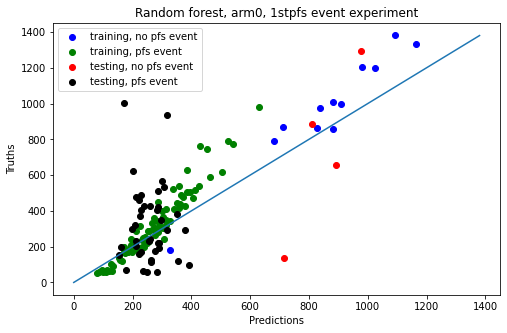

In [110]:
from sklearn.metrics import median_absolute_error, r2_score

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(range(a0data["dpfs"].max()), range(a0data["dpfs"].max()))
plt.title("Random forest, arm0, 1stpfs event experiment")
plt.xlabel("Predictions")
plt.ylabel("Truths")

ca0_y_train_pred_np = model.predict(ca0_x_train[ca0_x_train["1stpfs event"] == 0])
ca0_y_train_pred_p = model.predict(ca0_x_train[ca0_x_train["1stpfs event"] == 1])

plt.scatter(
    ca0_y_train_pred_np,
    ca0_y_train[ca0_y_train["1stpfs event"] == 0]["dpfs"],
    c="blue",
    label="training, no pfs event",
)
plt.scatter(
    ca0_y_train_pred_p,
    ca0_y_train[ca0_y_train["1stpfs event"] == 1]["dpfs"],
    c="green",
    label="training, pfs event",
)

ca0_y_pred_np = model.predict(ca0_x_test[ca0_x_test["1stpfs event"] == 0])
ca0_y_pred_p = model.predict(ca0_x_test[ca0_x_test["1stpfs event"] == 1])
plt.scatter(
    ca0_y_pred_np,
    ca0_y_test[ca0_y_test["1stpfs event"] == 0]["dpfs"],
    c="red",
    label="testing, no pfs event",
)
plt.scatter(
    ca0_y_pred_p,
    ca0_y_test[ca0_y_test["1stpfs event"] == 1]["dpfs"],
    c="black",
    label="testing, pfs event",
)

ax.legend()
plt.show()

#### arm1

In [111]:
_ = model.fit(ca1_x_train, ca1_y_train["dpfs"])

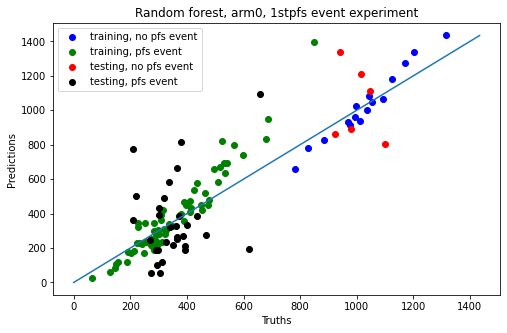

In [112]:
from sklearn.metrics import median_absolute_error, r2_score

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(range(a1data["dpfs"].max()), range(a1data["dpfs"].max()))
plt.title("Random forest, arm0, 1stpfs event experiment")
plt.ylabel("Predictions")
plt.xlabel("Truths")

ca1_y_train_pred_np = model.predict(ca1_x_train[ca1_x_train["1stpfs event"] == 0])
ca1_y_train_pred_p = model.predict(ca1_x_train[ca1_x_train["1stpfs event"] == 1])

plt.scatter(
    ca1_y_train_pred_np,
    ca1_y_train[ca1_y_train["1stpfs event"] == 0]["dpfs"],
    c="blue",
    label="training, no pfs event",
)
plt.scatter(
    ca1_y_train_pred_p,
    ca1_y_train[ca1_y_train["1stpfs event"] == 1]["dpfs"],
    c="green",
    label="training, pfs event",
)

ca1_y_pred_np = model.predict(ca1_x_test[ca1_x_test["1stpfs event"] == 0])
ca1_y_pred_p = model.predict(ca1_x_test[ca1_x_test["1stpfs event"] == 1])
plt.scatter(
    ca1_y_pred_np,
    ca1_y_test[ca1_y_test["1stpfs event"] == 0]["dpfs"],
    c="red",
    label="testing, no pfs event",
)
plt.scatter(
    ca1_y_pred_p,
    ca1_y_test[ca1_y_test["1stpfs event"] == 1]["dpfs"],
    c="black",
    label="testing, pfs event",
)

ax.legend()
plt.show()

--------

In [113]:
from IPython.display import display, Markdown

mk_table = """
----
## Recap of regression results
| Name | arm0 training MAE, r2 | arm0 testing MAE, r2 | arm1 training MAE. r2 | arm1 testing MAE. r2 |
| - | :-: | :-: | :-: | :-: |
"""

table_line = "| **{name}** | {arm0tmae:.6f} {arm0tr2:.6f} | {arm0ttmae:.6f} {arm0ttr2:.6f} | {arm1tmae:.6f} {arm1tr2:.6f} | {arm1ttmae:.6f} {arm1ttr2:.6f} |\n"

for model in evaluation:
    mk_table += table_line.format(
        name=model,
        arm0tmae=evaluation[model]["arm0"][0][0],
        arm0tr2=evaluation[model]["arm0"][0][1],
        arm0ttmae=evaluation[model]["arm0"][1][0],
        arm0ttr2=evaluation[model]["arm0"][1][1],
        arm1tmae=evaluation[model]["arm1"][0][0],
        arm1tr2=evaluation[model]["arm1"][0][1],
        arm1ttmae=evaluation[model]["arm1"][1][0],
        arm1ttr2=evaluation[model]["arm1"][1][1],
    )

display(Markdown(mk_table))


----
## Recap of regression results
| Name | arm0 training MAE, r2 | arm0 testing MAE, r2 | arm1 training MAE. r2 | arm1 testing MAE. r2 |
| - | :-: | :-: | :-: | :-: |
| **best-linear** | 133.738802 -0.062516 | 122.265734 -0.183139 | 115.106322 0.053791 | 97.907942 -0.096652 |
| **best-lasso** | 103.471634 -0.091408 | 108.528366 -0.029175 | 126.500000 -0.064446 | 108.500000 -0.022082 |
| **best-random-forest** | 33.595421 0.786506 | 124.305272 -0.463559 | 52.579988 0.679416 | 134.371521 -0.079727 |
| **best-decision-tree** | 0.000000 0.996682 | 217.500000 -1.900298 | 24.000000 0.676039 | 179.000000 -0.634290 |
| **best-decision-tree-cv** | 29.781233 0.588955 | 125.465841 -1.559988 | 69.417504 0.394696 | 123.000000 0.133659 |
| **best-svr-poly** | 97.054823 0.085868 | 95.704371 -0.077007 | 102.958583 0.022329 | 125.623912 -0.078718 |
| **all-linear** | 77.926937 0.335675 | 166.315256 -4.730937 | 86.034061 0.224504 | nan nan |
| **all-lasso** | 103.471634 -0.091408 | 108.528366 -0.029175 | 126.500000 -0.064446 | 108.500000 -0.022082 |
| **all-random-forest** | 35.715139 0.748633 | 130.967867 -0.387720 | 48.407332 0.759808 | 99.306125 0.004471 |
| **all-decision-tree** | 0.000000 0.930060 | 210.248147 -2.137388 | 0.000000 0.990701 | 227.000000 -0.909770 |
| **all-svr-poly** | 92.812807 0.116966 | 121.366837 0.017712 | 95.763977 0.104123 | 117.934162 -0.124604 |
| **clinical-ridge** | 120.601637 0.049677 | 106.284002 -0.049021 | 136.544432 0.135411 | 168.352058 -0.355174 |
| **clinical-random-forest** | 42.005804 0.760382 | 136.660982 -0.539441 | 58.013799 0.699968 | 111.796076 0.108145 |
| **clinical-decision-tree** | 56.000000 0.490261 | 132.154074 -2.094696 | 75.563594 0.329235 | 133.745170 -0.199053 |
| **clinical-decision-tree-cv** | 48.365157 0.506243 | 132.700738 -1.251303 | 93.627675 0.181146 | 134.000000 0.048363 |
| **clinical-all-ridge** | 77.222438 0.276541 | 135.271244 -8.501652 | 81.465483 0.491567 | 268.684614 -8.839670 |
| **clinical-all-random-forest** | 38.892355 0.771914 | 121.298679 -0.114867 | 44.716362 0.726292 | 128.854897 0.124603 |
| **clinical-all-random-forest-cv** | 58.191999 0.435530 | 119.028354 -0.081480 | 70.986993 0.299903 | 140.292155 0.059429 |
| **clinical-all-svr-rbf** | 28.975028 0.957574 | 85.943151 -0.009876 | 32.613163 0.959369 | 89.499992 -0.035608 |
| **clinical-all-svr-rbf-cv** | 53.520805 0.851210 | 86.545449 0.013944 | 58.461250 0.858293 | 89.500000 -0.064717 |
